## How we created People Sentiment and some visuals

imports

In [ ]:
import time
from datetime import datetime, timedelta
import json
import os
import requests
from bs4 import BeautifulSoup
import math
from urllib.parse import urlparse, parse_qs, urlunparse
from bs4 import BeautifulSoup
import pandas as pd
from pathlib import Path
import html
from langdetect import detect
import pytz
import re
import unicodedata
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm
import glob
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf



We first create the all_topics.json file that serves as the index for our scraper

In [ ]:
BASE_URL = "https://bitcointalk.org/"
BOARD_ID = 1  # 1 = Bitcoin Discussion
STEP = 40     # topics per page (offset increment)

# Stop once we reach topics whose last post is older than this:
CUTOFF_DATE = datetime(2013, 1, 1)

session = requests.Session()
session.headers["User-Agent"] = (
    "Mozilla/5.0 (compatible; BitcointalkScraper/0.1; +youremail@example.com)"
)

# ---------- helpers ----------

def parse_last_post_datetime(raw_text: str) -> datetime | None:
    """
    Convert 'Last post' string like:
        'November 24, 2025, 11:47:47 PM by Username'
        'Today at 10:58:33 PM by Username'
        'Yesterday at 03:21:09 AM by Username'
    into a datetime object.
    Returns None if parsing fails.
    """
    if not raw_text:
        return None

    # Drop the " by Username"
    text = raw_text.split(" by ", 1)[0].strip()

    today = datetime.now()

    # Today / Yesterday special cases
    if text.startswith("Today"):
        try:
            time_part = text.split(" at ", 1)[1].strip()
            t = datetime.strptime(time_part, "%I:%M:%S %p").time()
            return datetime.combine(today.date(), t)
        except Exception:
            return today

    if text.startswith("Yesterday"):
        try:
            time_part = text.split(" at ", 1)[1].strip()
            t = datetime.strptime(time_part, "%I:%M:%S %p").time()
            return datetime.combine((today - timedelta(days=1)).date(), t)
        except Exception:
            return today - timedelta(days=1)

    # Full date like 'November 24, 2025, 11:47:47 PM'
    for fmt in ("%B %d, %Y, %I:%M:%S %p", "%B %d, %Y, %H:%M:%S"):
        try:
            return datetime.strptime(text, fmt)
        except ValueError:
            continue

    return None

# gets rid of the pinned initial posts that aren't relevant
def is_sticky_row(row) -> bool:
    """
    Return True if this row is a pinned/sticky topic.

    We look for an <img> with:
      - src containing 'show_sticky'
      - or id starting with 'stickyicon'
    """
    for img in row.find_all("img"):
        src = (img.get("src") or "").lower()
        img_id = (img.get("id") or "").lower()
        if "show_sticky" in src or img_id.startswith("stickyicon"):
            return True
    return False


def get_topics_from_board_soup(soup, cutoff_date: datetime):
    """
    Extract topics from ONE board page.

    Returns:
        topics: list of dicts with keys:
            subject, thread_url, last_post_text, last_post_dt
        hit_cutoff: True if we reached a topic older than cutoff_date
                    (so caller should stop pagination).
    """
    topics = []
    hit_cutoff = False

    for row in soup.find_all("tr"):
        # Real board index topic link: ?topic=XXXXX.0
        subject_link = row.find(
            "a",
            href=lambda h: h and "topic=" in h and ".0" in h,
        )
        if not subject_link:
            continue

        # Skip sticky / pinned topics
        if is_sticky_row(row):
            continue

        subject = subject_link.get_text(strip=True)
        thread_url = url.join(BASE_URL, subject_link["href"])

        # Last post timestamp cell
        last_post_td = (
            row.find("td", class_="windowbg2 lastpostcol")
            or row.find("td", class_="windowbg lastpostcol")
        )
        last_post_text = None
        last_post_dt = None
        if last_post_td:
            small = last_post_td.find("span", class_="smalltext")
            if small:
                last_post_text = " ".join(small.stripped_strings)
                last_post_dt = parse_last_post_datetime(last_post_text)

        # If we can parse a date and it's before cutoff, stop here
        if last_post_dt is not None and last_post_dt < cutoff_date:
            hit_cutoff = True
            break

        topics.append(
            {
                "subject": subject,
                "thread_url": thread_url,
                "last_post_text": last_post_text,
                "last_post_dt": last_post_dt,
            }
        )

    return topics, hit_cutoff


def iterate_board_until_cutoff(board_id: int, cutoff_date: datetime, max_pages: int | None = None):
    """
    Iterate over board pages using the offset pattern:
        board=<id>.0, board=<id>.40, board=<id>.80, ...

    Yields (topics, url) until the cutoff_date is reached or max_pages is hit.
    """
    offset = 0
    page_num = 1

    while True:
        if max_pages is not None and page_num > max_pages:
            break

        url = f"{BASE_URL}index.php?board={board_id}.{offset};sort=last_post;desc"
        print(f"Fetching page {page_num}: {url}")

        resp = session.get(url)
        resp.raise_for_status()
        soup = BeautifulSoup(resp.text, "html.parser")

        topics, hit_cutoff = get_topics_from_board_soup(soup, cutoff_date)
        yield topics, url

        if hit_cutoff:
            print(f"Hit cutoff date on page {page_num}. Stopping pagination.")
            break

        if not topics:
            # no topics found -> nothing else to scrape
            print(f"No topics found on page {page_num}. Stopping.")
            break

        offset += STEP
        page_num += 1
        time.sleep(1)  

# ---------- main ----------

if __name__ == "__main__":
    all_topics = []

    for topics, url in iterate_board_until_cutoff(BOARD_ID, CUTOFF_DATE, max_pages=None):
        print(f"\n=== Page from {url} ===")
        print(f"Found {len(topics)} topics (non-sticky, before cutoff):\n")

        for t in topics[:5]:  # show just a few per page
            print(f"- {t['subject']}")
            print(f"  Last:  {t['last_post_text']}")
            print()

        all_topics.extend(topics)

    print(f"\nTOTAL topics collected in this run: {len(all_topics)}")

    # ---------- save all_topics.json for the chunk runner ----------

    OUTFILE = "all_topics.json"

    serializable_topics = []
    for i, t in enumerate(all_topics):
        d = dict(t)
        d["topic_index"] = i  

        # convert datetime -> ISO string so json.dump works
        if isinstance(d.get("last_post_dt"), datetime):
            d["last_post_dt"] = d["last_post_dt"].isoformat()
        else:
            d["last_post_dt"] = None

        serializable_topics.append(d)

    with open(OUTFILE, "w", encoding="utf-8") as f:
        json.dump(serializable_topics, f, indent=2, ensure_ascii=False)

    print(f"[OK] Wrote {len(serializable_topics)} topics to {OUTFILE}")



Fetching page 1: https://bitcointalk.org/index.php?board=1.0;sort=last_post;desc

=== Page from https://bitcointalk.org/index.php?board=1.0;sort=last_post;desc ===
Found 37 topics (non-sticky, before cutoff):

- Bitcoin and the holidays
  Last:  Today at 11:51:09 PM by Jcarlos10

- Are Coinjoins safe to use in everyday life?
  Last:  Today at 11:50:40 PM by alani123

- Bitcoin; a tool for spending or saving.
  Last:  Today at 11:49:22 PM by JeanC22

- The shortest Bitcoin question ever
  Last:  Today at 11:47:32 PM by Blour

- How to make sure your bitcoin reaches the next generation
  Last:  Today at 11:41:11 PM by Antona

Fetching page 2: https://bitcointalk.org/index.php?board=1.40;sort=last_post;desc

=== Page from https://bitcointalk.org/index.php?board=1.40;sort=last_post;desc ===
Found 40 topics (non-sticky, before cutoff):

- Bitcoin halving and global debt increase; two distinct economic activities.
  Last:  Today at 07:00:31 PM by CTO114

- Why do Government Need Bitcoin?
  L

Now that we have all_topics.json, we want to scrape actual content

In [ ]:
# =========================
# CONFIG
# =========================

ALL_TOPICS_FILE = "all_topics.json"   
PROGRESS_FILE = "progress.json"       # will be created automatically
OUTPUT_DIR = "chunks"                 # where each chunk JSONL will go

CHUNK_SIZE = 500                      # topics per chunk
THREAD_MAX_PAGES = 3                  # pages per thread
REQUEST_SLEEP = 1.0                   # seconds between HTTP requests
MAX_CONSEC_ERRORS = 10                # basic safety break if things go bad

# =========================
# HTTP SESSION
# =========================

session = requests.Session()
session.headers["User-Agent"] = (
    "Mozilla/5.0 (compatible; BitcointalkChunkScraper/0.1; +youremail@example.com)"
)

# =========================
# LOAD ALL_TOPICS
# =========================

with open(ALL_TOPICS_FILE, "r", encoding="utf-8") as f:
    all_topics = json.load(f)

num_topics = len(all_topics)
num_chunks = math.ceil(num_topics / CHUNK_SIZE)
print(f"[INIT] Loaded {num_topics} topics → {num_chunks} chunks total.")


# =========================
# LOAD / INIT PROGRESS
# =========================

if os.path.exists(PROGRESS_FILE):
    with open(PROGRESS_FILE, "r", encoding="utf-8") as f:
        progress = json.load(f)
        completed_chunks = set(progress.get("completed_chunks", []))
else:
    completed_chunks = set()

os.makedirs(OUTPUT_DIR, exist_ok=True)


def save_progress():
    data = {"completed_chunks": sorted(list(completed_chunks))}
    with open(PROGRESS_FILE, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2)
    print(f"[PROGRESS] Updated {PROGRESS_FILE}: {data}")


def mark_chunk_complete(chunk_id):
    completed_chunks.add(chunk_id)
    save_progress()


# =========================
# THREAD SCRAPING
# =========================

def scrape_thread_page(thread_page_url: str):
    """
    Scrape all posts on a single thread page.
    Returns list of {timestamp_raw, text} with quotes removed.
    """
    resp = session.get(thread_page_url)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")

    posts = []

    for post_cell in soup.select("td.td_headerandpost"):
        # Remove quoted blocks (quoted content from previous posts)
        for block in post_cell.select("div.quote, div.quoteheader"):
            block.decompose()

        content_div = post_cell.find("div", class_="post")
        if not content_div:
            continue
        text = " ".join(content_div.stripped_strings)

        time_div = post_cell.find("div", class_="smalltext")
        timestamp_raw = time_div.get_text(" ", strip=True) if time_div else None

        posts.append(
            {
                "timestamp_raw": timestamp_raw,
                "text": text,
            }
        )

    return posts


def scrape_entire_thread(thread_root_url: str, max_pages: int | None = None):
    """
    Scrape up to max_pages pages of a thread.
    thread_root_url should look like '...index.php?topic=5566220.0'
    Returns a list of posts (dicts with timestamp_raw, text).
    """
    parsed = urlparse(thread_root_url)
    qs = parse_qs(parsed.query)

    if "topic" not in qs:
        raise ValueError(f"URL lacks topic=: {thread_root_url}")

    topic_val = qs["topic"][0]   # e.g. '5566220.0'
    topic_id = topic_val.split(".")[0]

    all_posts = []
    offset = 0
    page_num = 1
    consec_errors = 0

    while True:
        if max_pages is not None and page_num > max_pages:
            break

        new_query = parsed.query.replace(topic_val, f"{topic_id}.{offset}")
        page_url = urlunparse(parsed._replace(query=new_query))

        try:
            print(f"      [THREAD] Page {page_num}: {page_url}")
            posts = scrape_thread_page(page_url)
            consec_errors = 0  # reset on success
        except Exception as e:
            consec_errors += 1
            print(f"      [THREAD] Error on page {page_num} of {thread_root_url}: {e}")
            if consec_errors >= MAX_CONSEC_ERRORS:
                print("      [THREAD] Too many consecutive errors. Giving up on this thread.")
                break
            time.sleep(REQUEST_SLEEP * 2)
            continue

        if not posts:
            break

        all_posts.extend(posts)

        offset += 20   # 20 posts per page
        page_num += 1
        time.sleep(REQUEST_SLEEP)

    return all_posts


# =========================
# CHUNK RUNNER
# =========================

def run_chunk(chunk_id: int):
    if chunk_id in completed_chunks:
        print(f"[SKIP] Chunk {chunk_id} already completed.")
        return

    start_idx = chunk_id * CHUNK_SIZE
    end_idx = min(start_idx + CHUNK_SIZE, num_topics)
    if start_idx >= num_topics:
        print(f"[SKIP] Chunk {chunk_id} is out of range (start={start_idx}).")
        return

    print(f"\n====== Running chunk {chunk_id}/{num_chunks - 1} ======")
    print(f"[CHUNK] Topic indices {start_idx} → {end_idx - 1}")

    out_path = os.path.join(
        OUTPUT_DIR,
        f"posts_{start_idx:05d}_{end_idx - 1:05d}.jsonl"
    )
    print(f"[CHUNK] Output file: {out_path}")

    topic_slice = all_topics[start_idx:end_idx]
    post_counter = 0

    with open(out_path, "w", encoding="utf-8") as f_out:
        for local_i, topic in enumerate(topic_slice):
            topic_index = start_idx + local_i
            subject = topic.get("subject")
            thread_url = topic.get("thread_url")
            last_post_text = topic.get("last_post_text")
            last_post_dt = topic.get("last_post_dt") 

            print(f"\n  [TOPIC {topic_index}] {subject}")
            print(f"    URL: {thread_url}")

            posts = scrape_entire_thread(thread_url, max_pages=THREAD_MAX_PAGES)
            print(f"    [TOPIC] Collected {len(posts)} posts")

            for p in posts:
                record = {
                    "topic_index": topic_index,
                    "topic_subject": subject,
                    "topic_url": thread_url,
                    "topic_last_post_text": last_post_text,
                    "topic_last_post_dt": last_post_dt,
                    "post_timestamp_raw": p["timestamp_raw"],
                    "post_text": p["text"],
                }
                f_out.write(json.dumps(record, ensure_ascii=False) + "\n")
                post_counter += 1

    print(f"[CHUNK DONE] Topics in this chunk: {len(topic_slice)}")
    print(f"[CHUNK DONE] Posts in this chunk:  {post_counter}")
    mark_chunk_complete(chunk_id)


def run_all_chunks():
    for chunk_id in range(num_chunks):
        run_chunk(chunk_id)


if __name__ == "__main__":
    # OPTION 1: run a single chunk (change the ID each run)
    # run_chunk(0)

    # OPTION 2: run all chunks, skipping ones already completed
    # run_all_chunks()

    START_CHUNK = 104   # inclusive
    END_CHUNK   = 110   # inclusive

    for chunk_id in range(START_CHUNK, END_CHUNK + 1):
        run_chunk(chunk_id)


[INIT] Loaded 55399 topics → 111 chunks total.

====== Running chunk 104/110 ======
[CHUNK] Topic indices 52000 → 52499
[CHUNK] Output file: chunks\posts_52000_52499.jsonl

  [TOPIC 52000] Dwolla stops support for virtual currencies
    URL: https://bitcointalk.org/index.php?topic=309022.0
      [THREAD] Page 1: https://bitcointalk.org/index.php?topic=309022.0
      [THREAD] Page 2: https://bitcointalk.org/index.php?topic=309022.20
      [THREAD] Page 3: https://bitcointalk.org/index.php?topic=309022.40
    [TOPIC] Collected 60 posts

  [TOPIC 52001] 40 minutes since last confirmed block - that's scary
    URL: https://bitcointalk.org/index.php?topic=316957.0
      [THREAD] Page 1: https://bitcointalk.org/index.php?topic=316957.0
      [THREAD] Page 2: https://bitcointalk.org/index.php?topic=316957.20
      [THREAD] Page 3: https://bitcointalk.org/index.php?topic=316957.40
    [TOPIC] Collected 51 posts

  [TOPIC 52002] Introducing the Pain Series
    URL: https://bitcointalk.org/index

Sanity check that the results were successfully scraped and outputting it to a final csv/parquet file

In [ ]:
data_dir = Path("C:/******/chunks")

jsonl_files = sorted(data_dir.glob("*.jsonl"))
print("Found", len(jsonl_files), "files")


frames = []

for fp in jsonl_files:
    df_part = pd.read_json(fp, lines=True)
    frames.append(df_part)

df = pd.concat(frames, ignore_index = True)
# Export final dataset
df.to_csv("bitcoin_talk_all.csv", index=False)
df.to_parquet("bitcoin_talk_all.parquet", index=False)


print("Final shape:", df.shape)
print("Export complete!")

Found 111 files
Final shape: (1834383, 7)
Export complete!


What's our resulting dataset like?

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1834383 entries, 0 to 1834382
Data columns (total 7 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   topic_index           int64 
 1   topic_subject         object
 2   topic_url             object
 3   topic_last_post_text  object
 4   topic_last_post_dt    object
 5   post_timestamp_raw    object
 6   post_text             object
dtypes: int64(1), object(6)
memory usage: 98.0+ MB


In [34]:
df.head()

,topic_index,topic_subject,topic_url,topic_last_post_text,topic_last_post_dt,post_timestamp_raw,post_text
0,0,Ever Asked Yourself If Bitcoin Could Ever Stop?,https://bitcointalk.org/index.php?topic=5566533.0,Today at 07:53:10 PM by Alvin_talk,2025-11-25T19:53:10,"November 25, 2025, 07:35:10 PM",Have you ever wondered what would happen if al...
1,0,Ever Asked Yourself If Bitcoin Could Ever Stop?,https://bitcointalk.org/index.php?topic=5566533.0,Today at 07:53:10 PM by Alvin_talk,2025-11-25T19:53:10,"November 25, 2025, 07:53:10 PM",What if the sun collapse to the surface of the...
2,0,Ever Asked Yourself If Bitcoin Could Ever Stop?,https://bitcointalk.org/index.php?topic=5566533.0,Today at 07:53:10 PM by Alvin_talk,2025-11-25T19:53:10,"November 25, 2025, 08:24:07 PM",These are rhetorics that will not happen becau...
3,0,Ever Asked Yourself If Bitcoin Could Ever Stop?,https://bitcointalk.org/index.php?topic=5566533.0,Today at 07:53:10 PM by Alvin_talk,2025-11-25T19:53:10,"November 25, 2025, 08:26:37 PM","So, is Bitcoin really immortal? It will never ..."
4,0,Ever Asked Yourself If Bitcoin Could Ever Stop?,https://bitcointalk.org/index.php?topic=5566533.0,Today at 07:53:10 PM by Alvin_talk,2025-11-25T19:53:10,"November 25, 2025, 08:50:00 PM","So is gold really immortal? It will never die,..."


Cleaning the dataframe

In [ ]:
df_clean = df.copy()

# ===== 1. TIMESTAMP → DATE (ET -> UTC -> YYYY-MM-DD) =====
eastern = pytz.timezone("US/Eastern")

timestamp_regex = re.compile(
    r"[A-Za-z]+ \d{1,2}, \d{4}, \d{1,2}:\d{2}:\d{2} (AM|PM)"
)

def extract_first_timestamp(ts):
    if not isinstance(ts, str):
        return None
    m = timestamp_regex.search(ts)
    return m.group(0) if m else None

def parse_date_only(ts):
    raw_ts = extract_first_timestamp(ts)
    if raw_ts is None:
        return np.nan
    try:
        dt = datetime.strptime(raw_ts, "%B %d, %Y, %I:%M:%S %p")  # ET
        dt_et = eastern.localize(dt)
        dt_utc = dt_et.astimezone(pytz.utc)
        return dt_utc.date()
    except Exception:
        return np.nan

df_clean["post_date"] = df_clean["post_timestamp_raw"].apply(parse_date_only)


# ===== 2. TEXT CLEANING HELPERS =====
def clean_post_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"\[quote.*?\].*?\[/quote\]", "", text, flags=re.DOTALL | re.IGNORECASE)
    text = re.sub(r"\[/?\w+(=[^\]]+)?\]", " ", text)
    text = re.sub(r"http\S+", " ", text)
    text = html.unescape(text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def fix_mojibake(s):
    if not isinstance(s, str):
        return s
    try:
        return s.encode("latin1").decode("utf8")
    except Exception:
        return s

def normalize_unicode(text):
    if not isinstance(text, str):
        return text
    return unicodedata.normalize("NFKC", text)

def remove_ascii_dividers(text):
    return re.sub(r"[-_]{4,}", " ", text)

# ---- language detect ----
def detect_lang_safe(text):
    if not isinstance(text, str) or len(text.strip()) < 20:
        return "unknown"
    try:
        return detect(text)
    except Exception:
        return "unknown"

# ===== 3. APPLY TEXT CLEANING =====
df_clean["clean_text"] = df_clean["post_text"].apply(clean_post_text)
df_clean["clean_text"] = df_clean["clean_text"].apply(fix_mojibake)
df_clean["clean_text"] = df_clean["clean_text"].apply(normalize_unicode)
df_clean["clean_text"] = df_clean["clean_text"].apply(remove_ascii_dividers)

df_clean["clean_text"] = (
    df_clean["clean_text"]
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# lowercase for classical sentiment models
df_clean["clean_text"] = df_clean["clean_text"].str.lower()

# =====  LANGUAGE FILTER =====
df_clean["lang"] = df_clean["clean_text"].apply(detect_lang_safe)
df_clean = df_clean[df_clean["lang"] == "en"].copy()

# ===== 4. FILTER ROWS / DROP DUPES =====
df_clean = df_clean.dropna(subset=["post_date", "clean_text"])
df_clean = df_clean[df_clean["clean_text"] != ""]
df_clean = df_clean[df_clean["clean_text"].str.len() > 10]

df_clean = df_clean.drop_duplicates(
    subset=["topic_index", "post_date", "clean_text"]
)

# ===== 5. FINAL SENTIMENT-READY FRAME =====
sent_df = df_clean[
    ["post_date", "clean_text", "topic_index", "topic_subject"]
].sort_values("post_date")


In [ ]:
sent_df

In [37]:
data = sent_df.copy()
data.drop(columns = ["sent_twitter"], inplace =True)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1262613 entries, 1340910 to 0
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   post_date      1262613 non-null  object
 1   clean_text     1262613 non-null  object
 2   topic_index    1262613 non-null  int64 
 3   topic_subject  1262590 non-null  object
dtypes: int64(1), object(3)
memory usage: 80.4+ MB


Saving the cleaned dataframe

In [40]:
data.to_parquet("cleaned_bitcoin_talk_full.parquet")

Setting up the sentiment models to do the scoring in batches

In [ ]:
# use laptop GPU if available; otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

@torch.no_grad()
def batched_sentiment_scores(texts, tokenizer, model, max_length=128, batch_size=32):
    """
    texts: pandas Series or list of strings
    returns: numpy array of scores in [-1, 1]
             score = p(positive) - p(negative)
    Assumes logits order is [negative, neutral, positive].
    """
    all_scores = []
    n = len(texts)

    for start in tqdm(range(0, n, batch_size)):
        batch = texts[start:start + batch_size].tolist()

        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )

        enc = {k: v.to(device) for k, v in enc.items()}

        outputs = model(**enc)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()  # (B, 3)

        scores = probs[:, 2] - probs[:, 0]  # p(pos) - p(neg)
        all_scores.append(scores)

    return np.concatenate(all_scores, axis=0)


Using device: cpu


Instantiating the RoBERTa sentiment model

In [ ]:
tw_model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tw_tokenizer = AutoTokenizer.from_pretrained(tw_model_name)
tw_model = AutoModelForSequenceClassification.from_pretrained(tw_model_name).to(device)
tw_model.eval()

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

c:\Users\Public\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Nancy Lonoff\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

Running the sentiment model with chunks

In [ ]:
texts = df["clean_text"].fillna("").astype(str)

df["sent_twitter"] = np.nan

chunk_size = 50000
n = len(df)

def run_twitter_chunk(chunk_idx):
    start = chunk_idx * chunk_size
    end = min(start + chunk_size, n)
    if start >= n:
        print("Chunk index out of range.")
        return

    # Check if this chunk already has values
    existing = df["sent_twitter"].iloc[start:end]
    if existing.notna().all():
        print(f"Chunk {chunk_idx} already complete, skipping.")
        return

    print(f"Running Twitter model for rows {start}–{end-1}")

    chunk_texts = texts.iloc[start:end]

    tw_scores = batched_sentiment_scores(
        chunk_texts,
        tokenizer=tw_tokenizer,
        model=tw_model,
        max_length=128,
        batch_size=16,
    )

    df.iloc[start:end, df.columns.get_loc("sent_twitter")] = tw_scores
    df.to_parquet(f"btc_talk_twitter/bitcointalk_with_twitter_partial_{chunk_idx}.parquet")

    print(f"Chunk {chunk_idx} done and saved.")


Run all the chunks if you want to

In [ ]:
def run_twitter_chunks(start_chunk, end_chunk, save_final=True):
    for chunk_idx in range(start_chunk, end_chunk + 1):
        print(f"\n=== Running chunk {chunk_idx} of Twitter sentiment ===")
        run_twitter_chunk(chunk_idx)

    print("\nAll requested chunks processed.")

    if save_final:
        outpath = "cleaned_bitcoin_talk_full_with_twitter.parquet"
        df.to_parquet(outpath, index=False)
        print(f"[OK] Saved final parquet: {outpath}")


While I used the NYU's Greene cluster to run all chunks, here is how you would combine them all together locally. The codes I used for that can be found at the end of the file

In [ ]:
# find all partial parquet files
files = sorted(glob.glob("bitcointalk_with_twitter_partial_*.parquet"))

print(f"Found {len(files)} partial files:")
for f in files:
    print("  ", f)

# read + concatenate
df_full = pd.concat(
    [pd.read_parquet(f) for f in files],
    ignore_index=True
)

print("Total rows:", len(df_full))
print("Columns:", df_full.columns.tolist())

# write merged parquet
df_full.to_parquet(
    "cleaned_bitcoin_talk_full_with_twitter.parquet",
    index=False
)


Examining the resulting dataframe 

In [ ]:
df_twitter = pd.read_parquet("cleaned_bitcoin_talk_full_with_twitter.parquet")

print(df.shape)
print(df.columns)
print(df[['clean_text', 'sent_twitter']].head())
print(df['sent_twitter'].describe())


(1262613, 6)
Index(['Unnamed: 0', 'post_date', 'clean_text', 'topic_index', 'topic_subject',
       'sent_twitter'],
      dtype='object')
                                          clean_text  sent_twitter
0  welcome to the new bitcoin forum! the old foru...      0.761789
1  it's important to have network connectivity wh...      0.365234
2  bitcoinbitcoin: bitcoin maturation posted:thu ...     -0.005170
3  there will be a proxy setting in version 0.2 s...      0.012125
4  anonguy54: request: make this anonymous? poste...      0.000119
count    1.262613e+06
mean    -2.604729e-02
std      5.406364e-01
min     -9.817596e-01
25%     -4.614879e-01
50%     -8.884522e-02
75%      3.961003e-01
max      9.924182e-01
Name: sent_twitter, dtype: float64


In [9]:
# df.drop(columns=["Unnamed: 0"], inplace = True)
df

,post_date,clean_text,topic_index,topic_subject,sent_twitter
0,2009-11-22,welcome to the new bitcoin forum! the old foru...,38557,Welcome to the new Bitcoin forum!,0.761789
1,2009-11-22,it's important to have network connectivity wh...,10700,Repost: Bitcoin Maturation,0.365234
2,2009-11-22,bitcoinbitcoin: bitcoin maturation posted:thu ...,10700,Repost: Bitcoin Maturation,-0.005170
3,2009-11-22,there will be a proxy setting in version 0.2 s...,1326,Repost: Request: Make this anonymous?,0.012125
4,2009-11-22,anonguy54: request: make this anonymous? poste...,1326,Repost: Request: Make this anonymous?,0.000119
...,...,...,...,...,...
1262608,2025-11-26,"there is an even simpler solution, a small adj...",4,Why Ray Dalio believes Bitcoin will never be a...,0.095263
1262609,2025-11-26,you actually explained it perfectly. investing...,19,How Do Long Term Bitcoin Holders Sell Their Bi...,-0.252542
1262610,2025-11-26,"we need bitcoin the most, because one of the t...",6,Bitcoin is everything we ever needs,0.345240
1262611,2025-11-26,the possibilities of all this happening is ver...,0,Ever Asked Yourself If Bitcoin Could Ever Stop?,-0.266795


Instantiating the FinBERT sentiment analysis now

In [ ]:
# FinBERT (financial sentiment)
fb_model_name = "ProsusAI/finbert"
fb_tokenizer = AutoTokenizer.from_pretrained(fb_model_name)
fb_model = AutoModelForSequenceClassification.from_pretrained(fb_model_name).to(device)
fb_model.eval()

Run Finbert on the full dataset.

Note: If you want to run in chunks, you use the same logic as RoBERTa. It's the same function

In [ ]:
texts = df["clean_text"].fillna("").astype(str)

df["sent_finbert"] = np.nan

chunk_size = 50000
n = len(df)

for start in range(0, n, chunk_size):
    end = min(start + chunk_size, n)
    print(f"FinBERT model: rows {start}–{end-1}")

    chunk_texts = texts[start:end]

    fb_scores = batched_sentiment_scores(
        chunk_texts,
        tokenizer=fb_tokenizer,
        model=fb_model,
        max_length=128,
        batch_size=32,
    )

    df.loc[start:end-1, "sent_finbert"] = fb_scores

df.to_parquet("bitcointalk_with_twitter_and_finbert.parquet")

Examining this dataframe

In [ ]:
df_fin = pd.read_parquet("cleaned_bitcoin_talk_full_finbert.parquet")

print(df_fin.shape)
print(df_fin.columns)
print(df_fin[['clean_text','sent_finbert']].head())


(1262613, 6)
Index(['Unnamed: 0', 'post_date', 'clean_text', 'topic_index', 'topic_subject',
       'sent_finbert'],
      dtype='object')
                                          clean_text  sent_finbert
0  welcome to the new bitcoin forum! the old foru...     -0.918885
1  it's important to have network connectivity wh...     -0.873239
2  bitcoinbitcoin: bitcoin maturation posted:thu ...     -0.909025
3  there will be a proxy setting in version 0.2 s...     -0.846169
4  anonguy54: request: make this anonymous? poste...     -0.924911


Comparing and filtering the sentiment datasets

In [ ]:
# --- Load both parquet files ---
tw_path = "cleaned_bitcoin_talk_full_with_twitter.parquet"
fb_path = "cleaned_bitcoin_talk_full_finbert.parquet"

df_tw = pd.read_parquet(tw_path)   # has sent_twitter
df_fb = pd.read_parquet(fb_path)   # has sent_finbert

print(df_tw.shape, df_fb.shape)


# Convert raw timestamp to datetime
df_tw["post_date"] = pd.to_datetime(
    df_tw["post_date"], 
    errors="coerce"
)

# filtering based on the range the original data covers
start = pd.Timestamp("2013-01-01")
end   = pd.Timestamp("2025-07-01")

mask = (df_tw["post_date"] >= start) & (df_tw["post_date"] <= end)

df_tw_filt = df_tw.loc[mask].copy()
df_fb_filt = df_fb.loc[mask].copy()   # same rows by position
print(df_tw_filt.shape, df_fb_filt.shape)


(1262613, 6) (1262613, 6)
(1217951, 6) (1217951, 6)


Combining the sentiment datasets

In [ ]:
# Sanity check: indices should line up
assert len(df_tw_filt) == len(df_fb_filt)

df_merged = df_tw_filt.copy()
df_merged["sent_finbert"] = df_fb_filt["sent_finbert"].values

# Quick check
df_merged[["clean_text", "sent_twitter", "sent_finbert"]].head()

,clean_text,sent_twitter,sent_finbert
20001,"to my surprise, i didn't find any mention of t...",0.425920,-0.917878
20002,i think it would be interesting to see who wil...,0.651747,-0.892112
20003,meanwhile in australia...,-0.101130,-0.707144
20004,i plan to attend.,0.489644,-0.899303
20005,why is that bitcointalk is the last to get win...,0.443263,-0.814572


Saving the full dataset with individual sentiment scores

In [103]:
# df_merged.drop(columns = ["Unnamed: 0"], inplace =True)
df_merged.to_csv("full_bitcoin_talk_sentiment.csv")

Rolling the sentiments up by day

In [104]:
daily = df_merged.groupby("post_date").agg(
    sent_twitter_mean = ("sent_twitter", "mean"),
    sent_finbert_mean = ("sent_finbert", "mean")
).reset_index()

daily.describe()

,post_date,sent_twitter_mean,sent_finbert_mean
count,4560,4560.000000,4560.000000
mean,2019-04-03 22:29:41.052631552,-0.033154,-0.608622
min,2013-01-01 00:00:00,-0.344301,-0.764462
25%,2016-02-19 18:00:00,-0.094014,-0.650996
50%,2019-04-04 12:00:00,-0.036384,-0.614619
75%,2022-05-18 06:00:00,0.025390,-0.573881
max,2025-07-01 00:00:00,0.327592,-0.252852
std,NaN,0.090224,0.062427


In [107]:
e = daily["ensemble"]

e_min = e.min()
e_max = e.max()

# scale to [0, 1]
e_01 = (e - e_min) / (e_max - e_min)

# then to [-1, 1]
e_mm = e_01 * 2 - 1

daily["sent_ensemble_scaled"] = e_mm
daily.describe()

,post_date,sent_twitter_mean,sent_finbert_mean,tw_z,fb_z,ensemble,sent_ensemble_scaled
count,4560,4560.000000,4560.000000,4560.000000,4.560000e+03,4.560000e+03,4560.000000
mean,2019-04-03 22:29:41.052631552,-0.033154,-0.608622,0.000000,1.209169e-15,3.926684e-16,-0.145675
min,2013-01-01 00:00:00,-0.344301,-0.764462,-3.448604,-2.496375e+00,-2.033362e+00,-1.000000
25%,2016-02-19 18:00:00,-0.094014,-0.650996,-0.674545,-6.787796e-01,-4.628170e-01,-0.340130
50%,2019-04-04 12:00:00,-0.036384,-0.614619,-0.035799,-9.606789e-02,-6.535097e-02,-0.173133
75%,2022-05-18 06:00:00,0.025390,-0.573881,0.648873,5.565157e-01,4.054686e-01,0.024684
max,2025-07-01 00:00:00,0.327592,-0.252852,3.998330,5.699018e+00,2.726802e+00,1.000000
std,NaN,0.090224,0.062427,1.000000,1.000000e+00,6.654095e-01,0.279574


Standardizing sentiment scores, creating ensemble score, and normalizing it. 

In [ ]:
# z-score each model’s daily mean
tw = daily["sent_twitter_mean"]
fb = daily["sent_finbert_mean"]

daily["tw_z"] = (tw - tw.mean()) / tw.std()
daily["fb_z"] = (fb - fb.mean()) / fb.std()

# picking model weights
w_tw = 0.8
w_fb = 0.2

daily["sent_ensemble_z"] = w_fb * daily["fb_z"] + w_tw * daily["tw_z"]

# rescale ensemble to [-1, 1] just for plotting / dashboards
e = daily["sent_ensemble_z"]
e_min, e_max = e.min(), e.max()

e_01 = (e - e_min) / (e_max - e_min)
daily["sent_ensemble"] = e_01 * 2 - 1


The resulting histogram of the ensemble scores

array([[<Axes: title={'center': 'sent_ensemble'}>]], dtype=object)

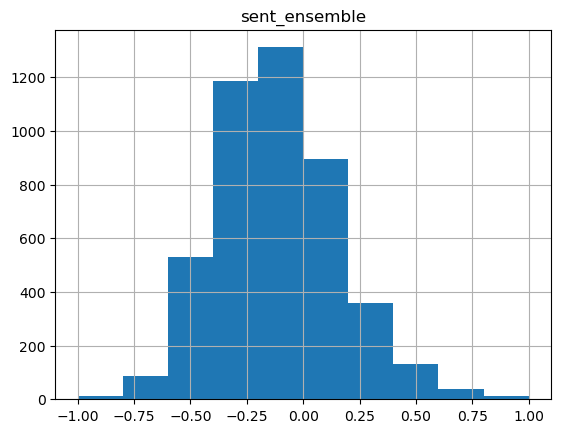

In [110]:
daily.hist("sent_ensemble")

Here's the sentiment over time

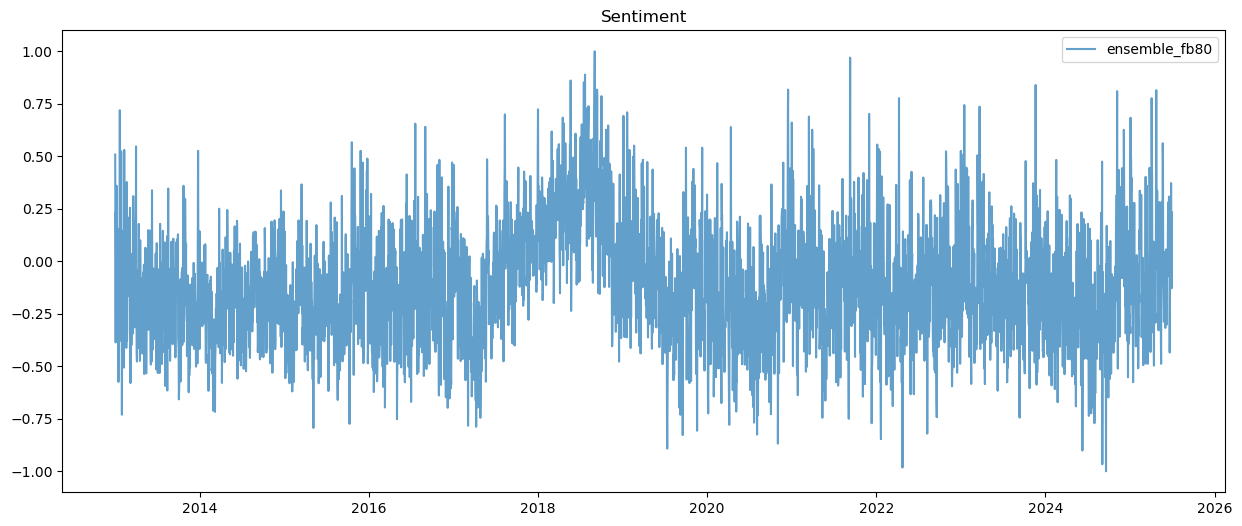

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(daily["post_date"], daily["sent_ensemble"], label=name, alpha=0.7)

plt.legend()
plt.title("Sentiment")
plt.show()


Saving the ensemble dataframe

In [ ]:
daily.to_csv("btc_talk_ensemble_data.csv", index=False)
df.to_parquet("full_bitcoin_talk_sentiment.parquet", index=False)

In [58]:
df = pd.read_csv("btc_talk_ensemble_data.csv")
df

,Unnamed: 0,post_date,sent_twitter_mean,sent_finbert_mean,tw_z,fb_z,ensemble,sent_ensemble_scaled,sent_ensemble_z,sent_ensemble
0,0,2013-01-01,0.195476,-0.695475,2.534016,-1.391287,1.356425,0.424231,1.748956,0.508156
1,1,2013-01-02,0.075546,-0.673517,1.204775,-1.039549,0.531478,0.077627,0.755910,0.154976
2,2,2013-01-03,-0.094219,-0.678817,-0.676819,-1.124445,-0.811106,-0.486465,-0.766344,-0.386418
3,3,2013-01-04,0.122990,-0.734035,1.730617,-2.008974,0.608740,0.110089,0.982699,0.235634
4,4,2013-01-05,-0.009538,-0.655165,0.261741,-0.745567,-0.040451,-0.162671,0.060280,-0.092427
...,...,...,...,...,...,...,...,...,...,...
4555,4555,2025-06-27,0.108492,-0.573791,1.569935,0.557949,1.266339,0.386381,1.367537,0.372503
4556,4556,2025-06-28,-0.014431,-0.521407,0.207511,1.397083,0.564382,0.091452,0.445425,0.044551
4557,4557,2025-06-29,-0.083508,-0.482293,-0.558107,2.023634,0.216415,-0.054748,-0.041759,-0.128718
4558,4558,2025-06-30,0.005023,-0.603486,0.423129,0.082275,0.320872,-0.010860,0.354958,0.012376


Here are some visuals that help add context to the sentiment data.

First is a distribution plot.

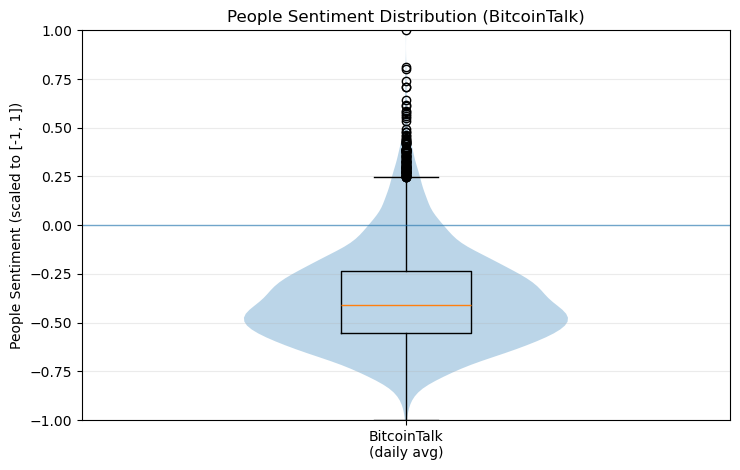

count    4560.000000
mean       -0.373996
std         0.253336
min        -1.000000
5%         -0.727964
25%        -0.552506
50%        -0.410359
75%        -0.233234
95%         0.115505
max         1.000000
Name: people_sent, dtype: float64
Days: 4560 Posts: 4560


In [ ]:
people_path = "btc_talk_ensemble_data.csv"

w_finbert = 0.7
w_other   = 0.3 


preferred_existing_col = None  # set to a string if you want to use an existing column

# ======================
# LOAD + BASIC CLEAN
# ======================
people = pd.read_csv(people_path)

people["post_date"] = pd.to_datetime(people["post_date"])
people = people.sort_values("post_date")

# ======================
# BUILD ENSEMBLE (Z)
# ======================
if preferred_existing_col is not None and preferred_existing_col in people.columns:
    people["ensemble_z"] = pd.to_numeric(people[preferred_existing_col], errors="coerce")
else:
    candidate_pairs = [
        ("fb_z", "tw_z"),  # FinBERT z, Twitter/other z
        ("finbert_z", "roberta_z"),
        ("sent_finbert_z", "sent_roberta_z"),
        ("fb_z", "roberta_z"),
    ]

    found = None
    for a, b in candidate_pairs:
        if a in people.columns and b in people.columns:
            found = (a, b)
            break

    if found is None:
        raise ValueError(
            "Couldn't find model z-score columns. "
            f"Available columns: {list(people.columns)}"
        )

    finbert_col, other_col = found

    people[finbert_col] = pd.to_numeric(people[finbert_col], errors="coerce")
    people[other_col]   = pd.to_numeric(people[other_col], errors="coerce")

    people["ensemble_z"] = w_finbert * people[finbert_col] + w_other * people[other_col]

# ======================
# RESCALE TO [-1, 1]
# ======================
z = people["ensemble_z"].dropna()
zmin, zmax = z.min(), z.max()
people["ensemble_scaled"] = 2 * ((people["ensemble_z"] - zmin) / (zmax - zmin)) - 1

# ======================
# DAILY AGGREGATION
# ======================
daily = (
    people
    .assign(date=lambda x: x["post_date"].dt.floor("D"))
    .groupby("date", as_index=False)
    .agg(
        people_sent=("ensemble_scaled", "mean"),
        n_posts=("ensemble_scaled", "size")
    )
)

# Drop days without sentiment
daily = daily.dropna(subset=["people_sent"])

# ======================
# PLOT: VIOLIN + BOX
# ======================
vals = daily["people_sent"].values

plt.figure(figsize=(7.5, 4.8))

# Violin
parts = plt.violinplot(vals, positions=[1], showmeans=False, showmedians=False, showextrema=False)

plt.boxplot(
    vals,
    positions=[1],
    widths=0.2,
    vert=True,
    patch_artist=False,
    showfliers=True
)

plt.axhline(0, linewidth=1, alpha=0.6)
plt.ylim(-1, 1)

plt.xticks([1], ["BitcoinTalk\n(daily avg)"])
plt.ylabel("People Sentiment (scaled to [-1, 1])")
plt.title("People Sentiment Distribution (BitcoinTalk)")

plt.grid(True, axis="y", alpha=0.25)
plt.tight_layout()
plt.show()

summary = daily["people_sent"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
print(summary)
print("Days:", len(daily), "Posts:", int(daily["n_posts"].sum()))


Next examines the distribution of sentiment "runs". A run is any consecutive day where sentiment stays positive or negative.

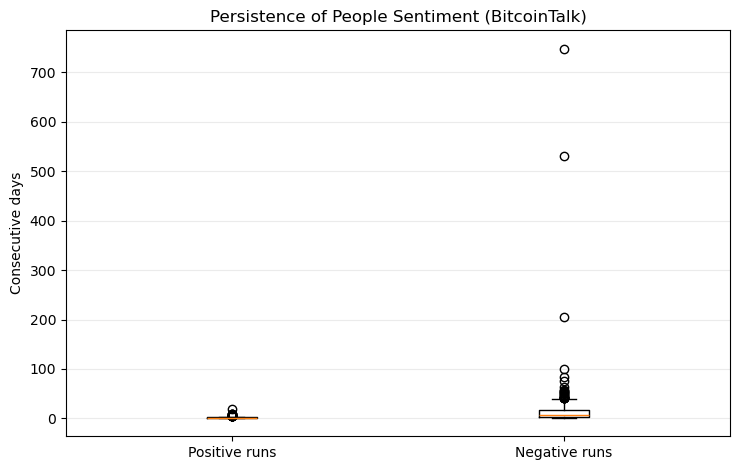

(count    208.000000
 mean       1.817308
 std        1.837686
 min        1.000000
 25%        1.000000
 50%        1.000000
 75%        2.000000
 max       18.000000
 Name: length, dtype: float64,
 count    209.000000
 mean      20.009569
 std       65.508513
 min        1.000000
 25%        2.000000
 50%        7.000000
 75%       17.000000
 max      748.000000
 Name: length, dtype: float64)

In [ ]:
# Sort by date
daily = daily.sort_values("date").reset_index(drop=True)

# Define sentiment sign
daily["sign"] = np.sign(daily["people_sent"])
daily = daily[daily["sign"] != 0] 

# Identify runs
runs = []
current_sign = daily.loc[0, "sign"]
run_length = 1

for i in range(1, len(daily)):
    if daily.loc[i, "sign"] == current_sign:
        run_length += 1
    else:
        runs.append({"sign": current_sign, "length": run_length})
        current_sign = daily.loc[i, "sign"]
        run_length = 1

runs.append({"sign": current_sign, "length": run_length})

runs_df = pd.DataFrame(runs)

# Split by sign
pos_runs = runs_df[runs_df["sign"] > 0]["length"]
neg_runs = runs_df[runs_df["sign"] < 0]["length"]

plt.figure(figsize=(7.5, 4.8))

plt.boxplot(
    [pos_runs, neg_runs],
    labels=["Positive runs", "Negative runs"],
    showfliers=True
)

plt.ylabel("Consecutive days")
plt.title("Persistence of People Sentiment (BitcoinTalk)")
plt.grid(True, axis="y", alpha=0.25)
plt.tight_layout()
plt.show()

pos_runs.describe(), neg_runs.describe()

Next we examine the autocorrelation between sentiment and different lags

<Figure size 850x450 with 0 Axes>

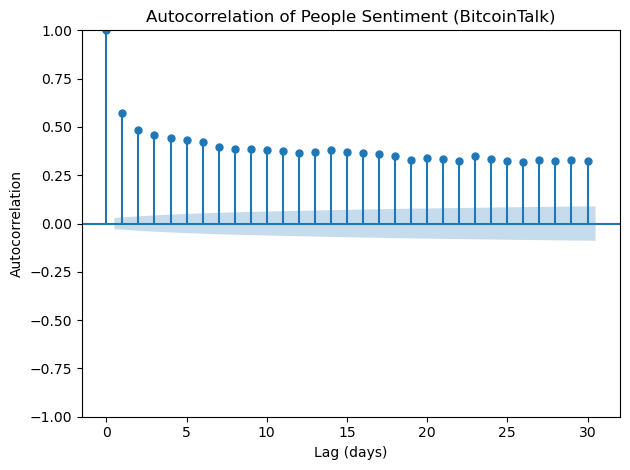

In [ ]:
ts = (
    daily
    .sort_values("date")["people_sent"]
    .dropna()
)

plt.figure(figsize=(8.5, 4.5))
plot_acf(
    ts,
    lags=30,          
    alpha=0.05
)

plt.title("Autocorrelation of People Sentiment (BitcoinTalk)")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

Lastly, following extreme sentiment days (10th and 90th percentiles), how does the sentiment the next day behave?

<Figure size 800x480 with 0 Axes>

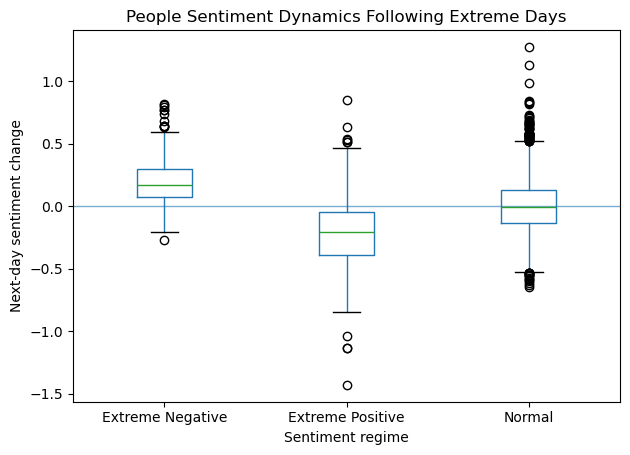

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
Extreme Negative,456.0,0.189861,0.180144,-0.269490,0.075616,0.172244,0.297636,0.814949
Extreme Positive,456.0,-0.202545,0.276544,-1.427256,-0.389929,-0.204570,-0.041942,0.848444
Normal,3647.0,0.001687,0.212682,-0.642183,-0.134152,-0.008199,0.128191,1.271565


In [ ]:
df = daily.sort_values("date").copy()

# Define extremes
q_lo = df["people_sent"].quantile(0.10)
q_hi = df["people_sent"].quantile(0.90)

df["group"] = "Normal"
df.loc[df["people_sent"] <= q_lo, "group"] = "Extreme Negative"
df.loc[df["people_sent"] >= q_hi, "group"] = "Extreme Positive"

# Next-day sentiment change
df["delta_next"] = df["people_sent"].shift(-1) - df["people_sent"]

plot_df = df.dropna(subset=["delta_next"])

# Boxplot
plt.figure(figsize=(8, 4.8))
plot_df.boxplot(
    column="delta_next",
    by="group",
    grid=False
)

plt.axhline(0, linewidth=1, alpha=0.6)
plt.suptitle("")
plt.title("People Sentiment Dynamics Following Extreme Days")
plt.ylabel("Next-day sentiment change")
plt.xlabel("Sentiment regime")
plt.tight_layout()
plt.show()

plot_df.groupby("group")["delta_next"].describe()


FinBERT on the cluster

In [ ]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm

# ---------- CONFIG ----------
INPUT_PATH = "cleaned_bitcoin_talk_full.csv"
OUTPUT_PATH = "/scratch/ml9542/btc_sentiment/cleaned_bitcoin_talk_full_finbert.parquet"
MODEL_NAME = "ProsusAI/finbert"  # FinBERT for financial text
MAX_LEN = 64
BATCH_SIZE = 64
# ----------------------------

print("Loading data from:", INPUT_PATH)

df = pd.read_csv(INPUT_PATH)
print("Rows:", len(df))

if "clean_text" not in df.columns:
    raise ValueError("Expected a 'clean_text' column in the dataframe.")

texts = df["clean_text"].fillna("").astype(str)

# If FinBERT column already exists, we only fill NaNs
if "sent_finbert" not in df.columns:
    df["sent_finbert"] = np.nan

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.set_num_threads(4)

print("Loading model:", MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device)
model.eval()

@torch.no_grad()
def batched_finbert_scores(texts_list, tokenizer, model, max_length=64, batch_size=64):
    """
    texts_list: list of strings
    returns: numpy array of scores in [-1, 1] = p(pos) - p(neg)

    NOTE: For ProsusAI/finbert, labels are typically:
      0: neutral, 1: positive, 2: negative
    So we use probs[:, 1] - probs[:, 2].
    """
    all_scores = []
    n = len(texts_list)
    for start in tqdm(range(0, n, batch_size), desc="FinBERT scoring"):
        batch = texts_list[start:start + batch_size]

        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        enc = {k: v.to(device) for k, v in enc.items()}

        outputs = model(**enc)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()

        # pos - neg (index 1 is positive, index 2 is negative)
        scores = probs[:, 1] - probs[:, 2]
        all_scores.append(scores)

    return np.concatenate(all_scores, axis=0)

# Only score rows that still need FinBERT
mask_missing = df["sent_finbert"].isna()
num_missing = mask_missing.sum()
print(f"Rows needing FinBERT sentiment: {num_missing}")

if num_missing > 0:
    texts_to_score = texts[mask_missing].tolist()
    scores = batched_finbert_scores(
        texts_to_score,
        tokenizer=tokenizer,
        model=model,
        max_length=MAX_LEN,
        batch_size=BATCH_SIZE,
    )
    df.loc[mask_missing, "sent_finbert"] = scores
else:
    print("No rows need FinBERT; 'sent_finbert' is already filled.")

print("Saving to:", OUTPUT_PATH)
df.to_parquet(OUTPUT_PATH)
print("Done.")

RoBERTa on the cluster

In [ ]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm

# ---------- CONFIG ----------
INPUT_PATH = "cleaned_bitcoin_talk_full.csv"   # change to .csv if you didn't convert
OUTPUT_PATH = "cleaned_bitcoin_talk_full_with_twitter.parquet"
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment"
MAX_LEN = 64
BATCH_SIZE = 64
# ----------------------------

print("Loading data from:", INPUT_PATH)

# Read data
if INPUT_PATH.endswith(".parquet"):
    df = pd.read_parquet(INPUT_PATH)
else:
    df = pd.read_csv(INPUT_PATH)

print("Rows:", len(df))

# Ensure we have a text column named 'clean_text'
# Change this if your column is named differently
if "clean_text" not in df.columns:
    raise ValueError("Expected a 'clean_text' column in the dataframe.")

texts = df["clean_text"].fillna("").astype(str)

# If sentiment column already exists, keep it and only fill NaNs
if "sent_twitter" not in df.columns:
    df["sent_twitter"] = np.nan

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.set_num_threads(4)

print("Loading model:", MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device)
model.eval()

@torch.no_grad()
def batched_sentiment_scores(texts_list, tokenizer, model, max_length=64, batch_size=64):
    """
    texts_list: list of strings (only for rows we still need to score)
    returns: numpy array of scores in [-1, 1] = p(pos) - p(neg)
    """
    all_scores = []
    n = len(texts_list)
    for start in tqdm(range(0, n, batch_size), desc="Scoring"):
        batch = texts_list[start:start + batch_size]
        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        enc = {k: v.to(device) for k, v in enc.items()}

        outputs = model(**enc)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()  # (B, 3)

        scores = probs[:, 2] - probs[:, 0]  # pos - neg
        all_scores.append(scores)

    return np.concatenate(all_scores, axis=0)

# Find rows that still need sentiment
mask_missing = df["sent_twitter"].isna()
num_missing = mask_missing.sum()
print(f"Rows needing Twitter sentiment: {num_missing}")

if num_missing > 0:
    texts_to_score = texts[mask_missing].tolist()
    scores = batched_sentiment_scores(
        texts_to_score,
        tokenizer=tokenizer,
        model=model,
        max_length=MAX_LEN,
        batch_size=BATCH_SIZE,
    )

    # Fill only the missing ones
    df.loc[mask_missing, "sent_twitter"] = scores
else:
    print("No rows need scoring; 'sent_twitter' is already filled.")

print("Saving to:", OUTPUT_PATH)
if OUTPUT_PATH.endswith(".parquet"):
    df.to_parquet(OUTPUT_PATH)
else:
    df.to_csv(OUTPUT_PATH, index=False)

print("Done.")